In [1]:
! pip install d2l==0.17.2
! pip install torchvision
! pip install torch-summary

Defaulting to user installation because normal site-packages is not writeable
  Using cached matplotlib-3.3.3-cp38-cp38-manylinux1_x86_64.whl (11.6 MB)
  Using cached requests-2.25.1-py2.py3-none-any.whl (61 kB)
  Using cached pandas-1.2.2-cp38-cp38-manylinux1_x86_64.whl (9.7 MB)
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.


In [2]:
import torch
import tarfile
import os
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchsummary import summary

Pre-computed the mean and std of the cifar 10 dataset.
Mean [0.49139968 0.48215841 0.44653091]
Standar dev [0.24703223 0.24348513 0.26158784] 
Using
mean = data.mean(axis = (0,1,2)) 
std = data.std(axis = (0,1,2))


In [3]:
train_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize([0.49139968, 0.48215841, 0.44653091],
                                                [0.24703223, 0.24348513, 0.26158784]),
                          transforms.RandomHorizontalFlip(0.6),
    transforms.RandomAdjustSharpness(0,0.5),
    transforms.Pad(4, padding_mode='reflect'),
            transforms.RandomCrop(32),
                            
                               
                                     ])
test_transforms =  transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize([0.49139968, 0.48215841, 0.44653091],
                                                [0.24703223, 0.24348513, 0.26158784]),
   
                                     ])


Calculate the mean and standard deviation of the CIFAR 10 data set to normalize the data before loading.

In [4]:
train_dataset = datasets.CIFAR10(root='./data',train=True,download=True,transform=train_transforms)
test_dataset = datasets.CIFAR10(root='./data',train=False,download=True, transform = test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=64, 
                                          shuffle=False)

In [6]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


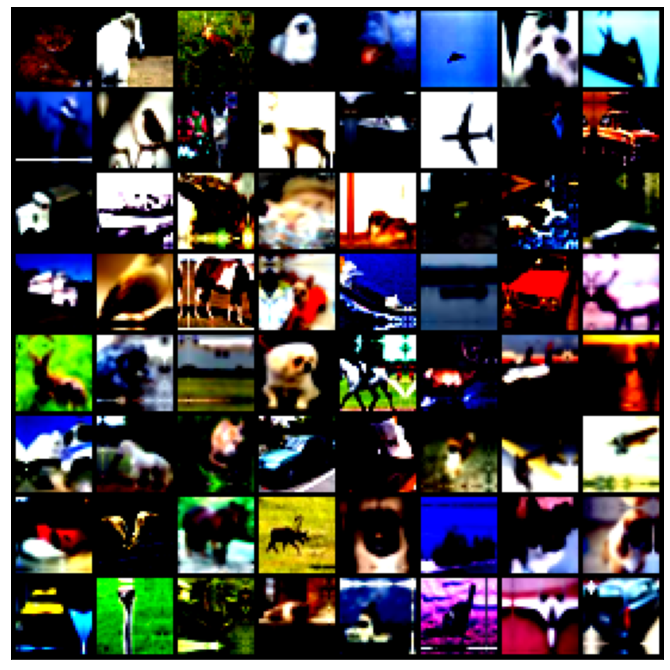

In [7]:
show_batch(train_loader)

In [8]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.dropout(out,0.4)
        out = (self.bn2(self.conv2(out)))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [9]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.dropout(out,0.1)
        out = self.layer4(out)
        out = F.dropout(out,0.3)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def project1_model():
    return ResNet(BasicBlock, [2, 1, 1, 1])

In [10]:
criterion = nn.CrossEntropyLoss()
model = project1_model().cuda()
# optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
optimizer = optim.Adam(model.parameters(),lr=0.001,betas=(0.9,0.999),eps=1e-08,weight_decay=0)
save_loss = {'train':[], 'test':[]}
save_acc = {'train':[], 'test':[]}
#print(model)

In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    # torch.numel() returns number of elements in a tensor

print(count_parameters(model))

4977226


In [12]:
print(summary(model))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            1,728
├─BatchNorm2d: 1-2                       128
├─Sequential: 1-3                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─Conv2d: 3-3                  36,864
|    |    └─BatchNorm2d: 3-4             128
|    |    └─Sequential: 3-5              --
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  36,864
|    |    └─BatchNorm2d: 3-7             128
|    |    └─Conv2d: 3-8                  36,864
|    |    └─BatchNorm2d: 3-9             128
|    |    └─Sequential: 3-10             --
├─Sequential: 1-4                        --
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 73,728
|    |    └─BatchNorm2d: 3-12            256
|    |    └─Conv2d: 3-13                 147,456
|    |    └─BatchNorm2d: 3-14        

In [18]:
for epoch in range(50):
  current_loss = 0.0
  current_corrects = 0
  test_loss = 0.0
  test_corrects = 0.0
  for batch_idx, (inputs, labels) in enumerate(train_loader):
    torch.autograd.set_detect_anomaly(True)
    model.train()
    optimizer.zero_grad()
    inputs = inputs.cuda()
    labels = labels.cuda()
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    current_loss += loss.item() * inputs.size(0)
    current_corrects += torch.sum(preds == labels.data)
  save_loss['train'] += [current_loss / len(train_loader.dataset)]
  save_acc['train'] += [current_corrects.float() / len(train_loader.dataset)]
  for batch_idy, (inputs, labels) in enumerate(test_loader):
    model.eval()
    with torch.no_grad():
      inputs = inputs.cuda()
      labels = labels.cuda()
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels)
    test_loss += loss.item() * inputs.size(0)
    test_corrects += torch.sum(preds == labels.data)
  save_loss['test'] += [test_loss / len(test_loader.dataset)]
  save_acc['test'] += [test_corrects.float() / len(test_loader.dataset)]

  print(f"Epoch:{epoch} -- Phase:{'train'} -- Loss:{save_loss['train'][-1]:.2f} -- Acc:{save_acc['train'][-1]*100:.2f}")        # pretty print
  print(f"Epoch:{epoch} -- Phase:{'test'} -- Loss:{save_loss['test'][-1]:.2f} -- Acc:{save_acc['test'][-1]*100:.2f}")

Epoch:0 -- Phase:train -- Loss:0.23 -- Acc:91.83
Epoch:0 -- Phase:test -- Loss:0.35 -- Acc:89.83
Epoch:1 -- Phase:train -- Loss:0.23 -- Acc:91.85
Epoch:1 -- Phase:test -- Loss:0.36 -- Acc:89.81
Epoch:2 -- Phase:train -- Loss:0.23 -- Acc:91.99
Epoch:2 -- Phase:test -- Loss:0.36 -- Acc:90.36
Epoch:3 -- Phase:train -- Loss:0.23 -- Acc:92.02
Epoch:3 -- Phase:test -- Loss:0.36 -- Acc:89.65
Epoch:4 -- Phase:train -- Loss:0.23 -- Acc:91.79
Epoch:4 -- Phase:test -- Loss:0.35 -- Acc:89.71
Epoch:5 -- Phase:train -- Loss:0.22 -- Acc:92.03
Epoch:5 -- Phase:test -- Loss:0.33 -- Acc:90.25
Epoch:6 -- Phase:train -- Loss:0.22 -- Acc:92.00
Epoch:6 -- Phase:test -- Loss:0.34 -- Acc:90.27
Epoch:7 -- Phase:train -- Loss:0.23 -- Acc:91.98
Epoch:7 -- Phase:test -- Loss:0.35 -- Acc:89.99
Epoch:8 -- Phase:train -- Loss:0.22 -- Acc:92.13
Epoch:8 -- Phase:test -- Loss:0.36 -- Acc:89.98
Epoch:9 -- Phase:train -- Loss:0.22 -- Acc:92.26
Epoch:9 -- Phase:test -- Loss:0.35 -- Acc:90.01
Epoch:10 -- Phase:train -- Los

Text(0.5, 1.0, 'Accuracy')

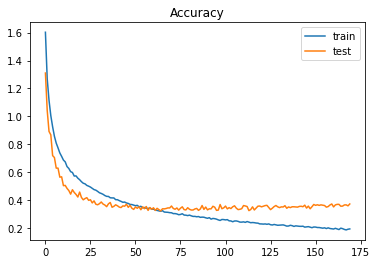

In [19]:
plt.plot(save_loss['train'])
plt.plot(save_loss['test'])
plt.legend(["train", "test"])
plt.title("Accuracy")

Text(0.5, 1.0, 'Accuracy')

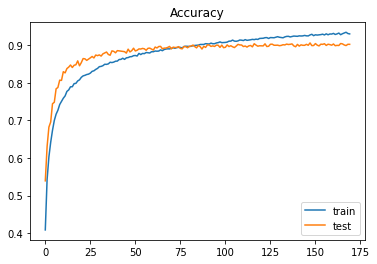

In [20]:
plt.plot(save_acc['train'])
plt.plot(save_acc['test'])
plt.legend(["train", "test"])
plt.title("Accuracy")

Label: cat , Predicted: cat


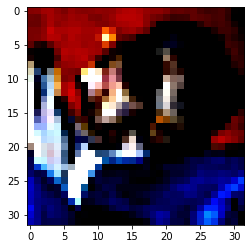

In [17]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = img.unsqueeze(0)
    xb=xb.cuda()
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_dataset.classes[preds[0].item()]
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_dataset.classes[label], ', Predicted:', predict_image(img, model))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: truck , Predicted: truck


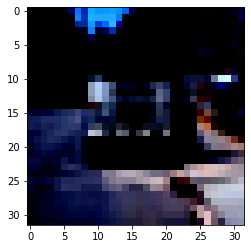

In [21]:
img, label = test_dataset[1008]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], ', Predicted:', predict_image(img, model))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: frog , Predicted: cat


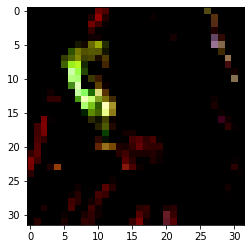

In [29]:
img, label = test_dataset[6152]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_dataset.classes[label], ', Predicted:', predict_image(img, model))

In [21]:
torch.save(model.state_dict(), 'project1_model_2.pt')